### Métodos de Newton y Región de Confianza


In [11]:
import numpy as np
import json
import time
from typing import Dict, List, Tuple, Any
import matplotlib.pyplot as plt
from scipy.linalg import solve




### Definición de la Función Objetivo
 
$$f(x, y) = -\tan(e^{-x^2}) - \tan(e^{-y^2})$$


In [12]:
def f(x: np.ndarray) -> float:
    """
    Función objetivo: f(x, y) = -tan(e^(-x²)) - tan(e^(-y²))
    
    Args:
        x: Array de forma (2,) con coordenadas [x, y]
    
    Returns:
        Valor de la función en el punto x
    """
    return -np.tan(np.exp(-x[0]**2)) - np.tan(np.exp(-x[1]**2))


def gradient_f(x: np.ndarray) -> np.ndarray:
    """
    Gradiente de f(x, y)
    
    ∇f = [2x·e^(-x²)·sec²(e^(-x²)), 2y·e^(-y²)·sec²(e^(-y²))]
    
    Args:
        x: Array de forma (2,) con coordenadas [x, y]
    
    Returns:
        Gradiente de la función en el punto x
    """
    grad = np.zeros(2)
    
    # Componente x
    exp_x = np.exp(-x[0]**2)
    sec2_x = 1 / np.cos(exp_x)**2
    grad[0] = 2 * x[0] * exp_x * sec2_x
    
    # Componente y
    exp_y = np.exp(-x[1]**2)
    sec2_y = 1 / np.cos(exp_y)**2
    grad[1] = 2 * x[1] * exp_y * sec2_y
    
    return grad


def hessian_f(x: np.ndarray) -> np.ndarray:
    """
    Matriz Hessiana de f(x, y)
    
    Como la función es separable, la Hessiana es diagonal:
    H = [[f_xx, 0], [0, f_yy]]
    
    f_xx = 2·e^(-x²)·sec²(e^(-x²))·(1 - 2x²) + 4x²·e^(-2x²)·sec²(e^(-x²))·tan(e^(-x²))
    
    Args:
        x: Array de forma (2,) con coordenadas [x, y]
    
    Returns:
        Matriz Hessiana 2x2 en el punto x
    """
    H = np.zeros((2, 2))
    
    # f_xx
    exp_x = np.exp(-x[0]**2)
    sec2_x = 1 / np.cos(exp_x)**2
    tan_x = np.tan(exp_x)
    H[0, 0] = (2 * exp_x * sec2_x * (1 - 2*x[0]**2) + 
               4 * x[0]**2 * exp_x**2 * sec2_x * tan_x)
    
    # f_yy
    exp_y = np.exp(-x[1]**2)
    sec2_y = 1 / np.cos(exp_y)**2
    tan_y = np.tan(exp_y)
    H[1, 1] = (2 * exp_y * sec2_y * (1 - 2*x[1]**2) + 
               4 * x[1]**2 * exp_y**2 * sec2_y * tan_y)
    
    # f_xy = f_yx = 0 (función separable)
    
    return H

###  Método de Newton

In [13]:
def newton_method(x0: np.ndarray, 
                  tol: float = 1e-8, 
                  max_iter: int = 100) -> Dict[str, Any]:
    """
    Método de Newton para optimización
    
    x^(k+1) = x^(k) - [H_f(x^(k))]^(-1) ∇f(x^(k))
    
    Args:
        x0: Punto inicial
        tol: Tolerancia para ||∇f||
        max_iter: Número máximo de iteraciones
    
    Returns:
        Diccionario con resultados del método
    """
    x = x0.copy()
    iterations = 0
    converged = False
    start_time = time.time()
    
    history = {
        'x': [x.copy()],
        'f': [f(x)],
        'grad_norm': [np.linalg.norm(gradient_f(x))]
    }
    
    for k in range(max_iter):
        grad = gradient_f(x)
        grad_norm = np.linalg.norm(grad)
        
        # Criterio de convergencia
        if grad_norm < tol:
            converged = True
            iterations = k
            break
        
        # Calcular Hessiana
        H = hessian_f(x)
        
        # Resolver H * d = -grad
        # Como H es diagonal, calcular inversa directamente: d = -H^(-1) * grad
        # Para matriz diagonal [[a, 0], [0, b]], la inversa es [[1/a, 0], [0, 1/b]]
        d = np.array([-grad[0] / H[0, 0], -grad[1] / H[1, 1]])
        
        # Actualizar
        x = x + d
        
        # Guardar historia
        history['x'].append(x.copy())
        history['f'].append(f(x))
        history['grad_norm'].append(grad_norm)
        
        iterations = k + 1
    
    elapsed_time = time.time() - start_time
    
    return {
        'x_min': x.tolist(),
        'f_min': f(x),
        'grad_norm': np.linalg.norm(gradient_f(x)),
        'num_iter': iterations,
        'converged': converged,
        'time_seconds': elapsed_time,
        'history': history
    }

###  Método de Región de Confianza

In [14]:
def solve_trust_region_subproblem(grad: np.ndarray, 
                                   H: np.ndarray, 
                                   delta: float) -> np.ndarray:
    """
    Resuelve el subproblema de región de confianza:
    min_p m(p) = g^T p + 1/2 p^T H p
    s.t. ||p|| <= delta
    
    Args:
        grad: Gradiente en el punto actual
        H: Matriz Hessiana en el punto actual
        delta: Radio de la región de confianza
    
    Returns:
        Paso p que resuelve el subproblema
    """
    # Caso especial: H diagonal (como en nuestra función)
    # Solución de Cauchy point mejorada
    
    # Intentar paso de Newton
    # Para matriz diagonal, calcular directamente: p = -H^(-1) * grad
    try:
        p_newton = np.array([-grad[0] / H[0, 0], -grad[1] / H[1, 1]])
        if np.linalg.norm(p_newton) <= delta:
            return p_newton
    except:
        pass
    
    # Si Newton no funciona o excede delta, usar dogleg o Cauchy point
    # Cauchy point: p_c = -tau * g donde tau minimiza m en dirección -g
    g_norm = np.linalg.norm(grad)
    if g_norm < 1e-10:
        return np.zeros_like(grad)
    
    # Calcular tau óptimo
    Hg = H @ grad
    gHg = grad @ Hg
    
    if gHg <= 0:
        tau = delta / g_norm
    else:
        tau = min(g_norm**3 / (delta * gHg), delta / g_norm)
    
    p_cauchy = -tau * grad
    
    # Si Cauchy point está en la frontera, devolverlo
    if np.linalg.norm(p_cauchy) >= 0.99 * delta:
        return p_cauchy * (delta / np.linalg.norm(p_cauchy))
    
    # Intentar combinar Cauchy y Newton (dogleg)
    p_newton = np.array([-grad[0] / H[0, 0], -grad[1] / H[1, 1]])
    p_newton = -solve(H, grad)
    p_diff = p_newton - p_cauchy
    
    # Encontrar tau tal que ||p_cauchy + tau * p_diff|| = delta
    a = np.dot(p_diff, p_diff)
    b = 2 * np.dot(p_cauchy, p_diff)
    c = np.dot(p_cauchy, p_cauchy) - delta**2
    
    discriminant = b**2 - 4*a*c
    if discriminant >= 0 and a > 1e-10:
        tau = (-b + np.sqrt(discriminant)) / (2*a)
        tau = min(max(tau, 0), 1)
        return p_cauchy + tau * p_diff
    
        
    
    return p_cauchy

In [15]:
def trust_region_method(x0: np.ndarray,
                        tol: float = 1e-8,
                        max_iter: int = 100,
                        delta0: float = 1.0,
                        delta_max: float = 10.0,
                        eta1: float = 0.1,
                        eta2: float = 0.75,
                        gamma1: float = 0.25,
                        gamma2: float = 2.0) -> Dict[str, Any]:
    """
    Método de Región de Confianza
    
    Args:
        x0: Punto inicial
        tol: Tolerancia para ||∇f||
        max_iter: Número máximo de iteraciones
        delta0: Radio inicial de la región de confianza
        delta_max: Radio máximo permitido
        eta1: Umbral para aceptar paso
        eta2: Umbral para aumentar delta
        gamma1: Factor de reducción de delta
        gamma2: Factor de aumento de delta
    
    Returns:
        Diccionario con resultados del método
    """
    x = x0.copy()
    delta = delta0
    iterations = 0
    converged = False
    rejected_steps = 0
    start_time = time.time()
    
    history = {
        'x': [x.copy()],
        'f': [f(x)],
        'grad_norm': [np.linalg.norm(gradient_f(x))],
        'delta': [delta],
        'rho': []
    }
    
    for k in range(max_iter):
        grad = gradient_f(x)
        grad_norm = np.linalg.norm(grad)
        
        # Criterio de convergencia
        if grad_norm < tol:
            converged = True
            iterations = k
            break
        
        # Calcular Hessiana
        H = hessian_f(x)
        
        # Resolver subproblema de región de confianza
        p = solve_trust_region_subproblem(grad, H, delta)
        
        # Calcular razón de reducción
        f_current = f(x)
        f_trial = f(x + p)
        
        # Reducción actual
        actual_reduction = f_current - f_trial
        
        # Reducción predicha por el modelo cuadrático
        predicted_reduction = -(grad @ p + 0.5 * p @ H @ p)
        
        # Razón rho
        if abs(predicted_reduction) < 1e-14:
            rho = 0
        else:
            rho = actual_reduction / predicted_reduction
        
        history['rho'].append(rho)
        
        # Decidir si aceptar el paso
        if rho > eta1:
            x = x + p
            accepted = True
        else:
            accepted = False
            rejected_steps += 1
        
        # Ajustar radio de confianza
        if rho < eta1:
            delta = gamma1 * delta
        elif rho >= eta2 and np.linalg.norm(p) >= 0.99 * delta:
            delta = min(gamma2 * delta, delta_max)
        
        # Guardar historia
        if accepted:
            history['x'].append(x.copy())
            history['f'].append(f(x))
            history['grad_norm'].append(np.linalg.norm(gradient_f(x)))
        history['delta'].append(delta)
        
        iterations = k + 1
    
    elapsed_time = time.time() - start_time
    
    return {
        'x_min': x.tolist(),
        'f_min': f(x),
        'grad_norm': np.linalg.norm(gradient_f(x)),
        'num_iter': iterations,
        'converged': converged,
        'rejected_steps': rejected_steps,
        'time_seconds': elapsed_time,
        'history': history
    }

### Leer Json con los Experimentos

In [16]:

def ReadJson(path):
    with open(path, 'r') as exp:
        return json.load(exp)


newton_experiments = ReadJson('newton_exp.json')
region_experiments = ReadJson('region_exp.json')


###  Experimentos con Método de Newton

In [17]:
# Ejecutar experimentos con Método de Newton
 

newton_results = []

for i, exp in enumerate(newton_experiments):
    x0 = exp['x0']
 
    
    # Llamar al método de Newton con los parámetros del JSON
    result = newton_method(
        np.array(x0), 
        tol=exp['tol'], 
        max_iter=exp['max_iter']
    )
    
    newton_results.append({
        'x0': x0,
        'result': result
    })
    
 

In [18]:
# Ejecutar experimentos con Método de Región de Confianza
 

trust_region_results = []

for i, exp in enumerate(region_experiments):
    x0 = exp['x0']
 
    
    # Llamar al método de Región de Confianza con los parámetros del JSON
    result = trust_region_method(
        np.array(x0),
        tol=exp['tol'],
        max_iter=exp['max_iter'],
        delta0=exp['delta0'],
        delta_max=exp['delta_max'],
        eta1=exp['eta1'],
        eta2=exp['eta2'],
        gamma1=exp['gamma1'],
        gamma2=exp['gamma2']
    )
    
    trust_region_results.append({
        'x0': x0,
        'result': result
    })
    
 

### Exportar Resultados a JSON

In [19]:
json_newton = []
for exp in newton_results:
    json_newton.append({
        'x0': exp['x0'],
        'newton': {
            'x_min': exp['result']['x_min'],
            'f_min': exp['result']['f_min'],
            'grad_norm': exp['result']['grad_norm'],
            'num_iter': exp['result']['num_iter'],
            'converged': exp['result']['converged'],
            'time_seconds': exp['result']['time_seconds']
        }
    })

 
with open('results_newton.json', 'w') as f:
    json.dump(json_newton, f, indent=4)

 

 
json_trust_region = []
for exp in trust_region_results:
    json_trust_region.append({
        'x0': exp['x0'],
        'trust_region': {
            'x_min': exp['result']['x_min'],
            'f_min': exp['result']['f_min'],
            'grad_norm': exp['result']['grad_norm'],
            'num_iter': exp['result']['num_iter'],
            'rejected_steps': exp['result']['rejected_steps'],
            'converged': exp['result']['converged'],
            'time_seconds': exp['result']['time_seconds']
        }
    })

# Guardar JSON - Trust Region
with open('results_trust_region.json', 'w') as f:
    json.dump(json_trust_region, f, indent=4)

 

### Gráficas de Convergencia por Experimento

Generando gráficas de convergencia...



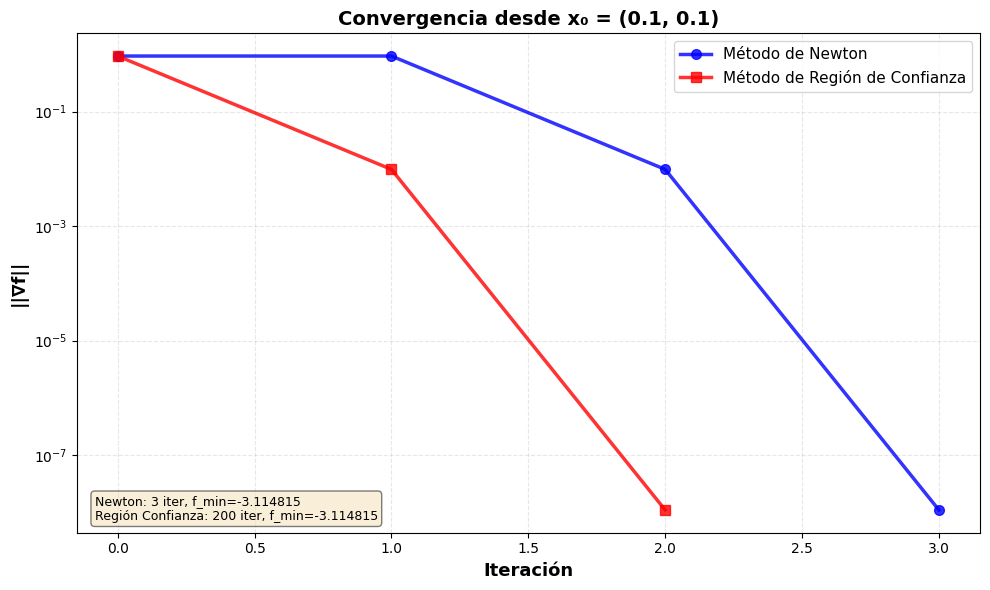

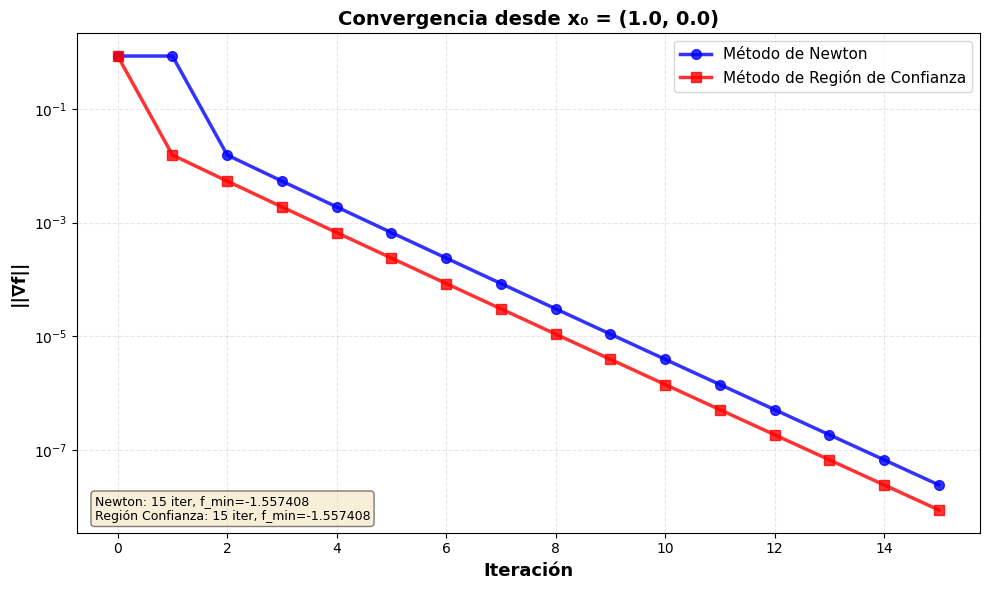

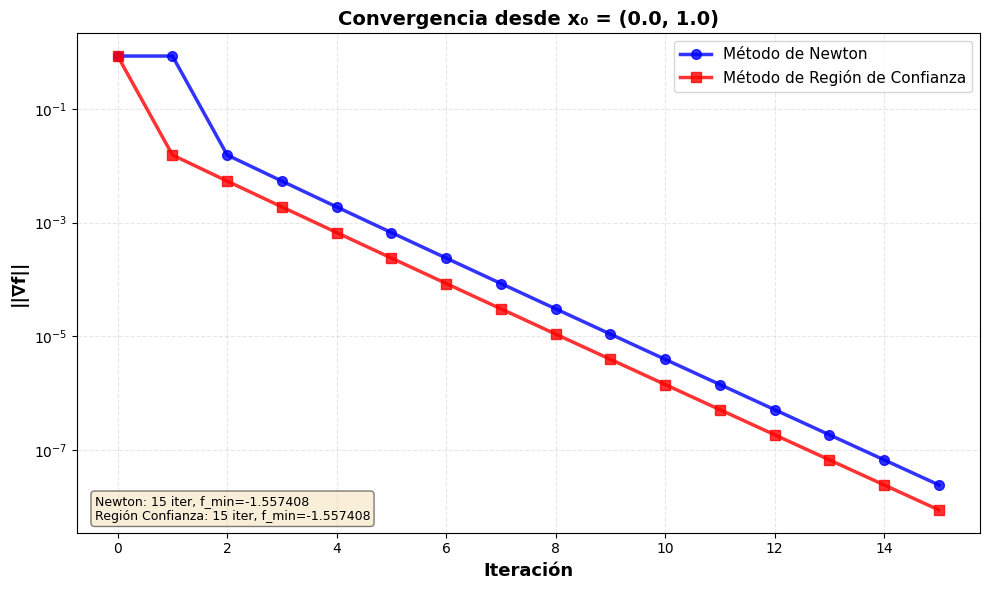

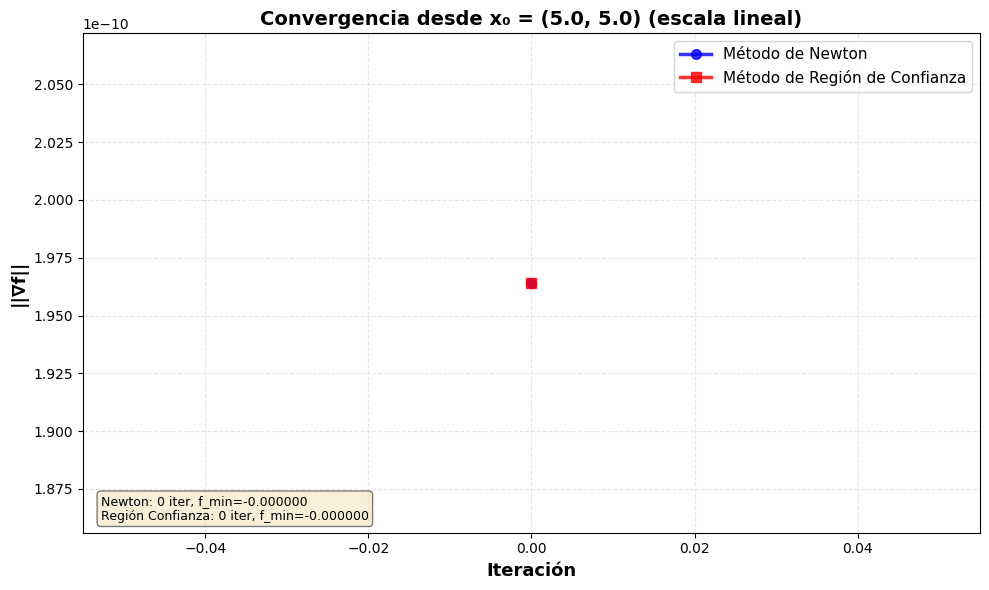

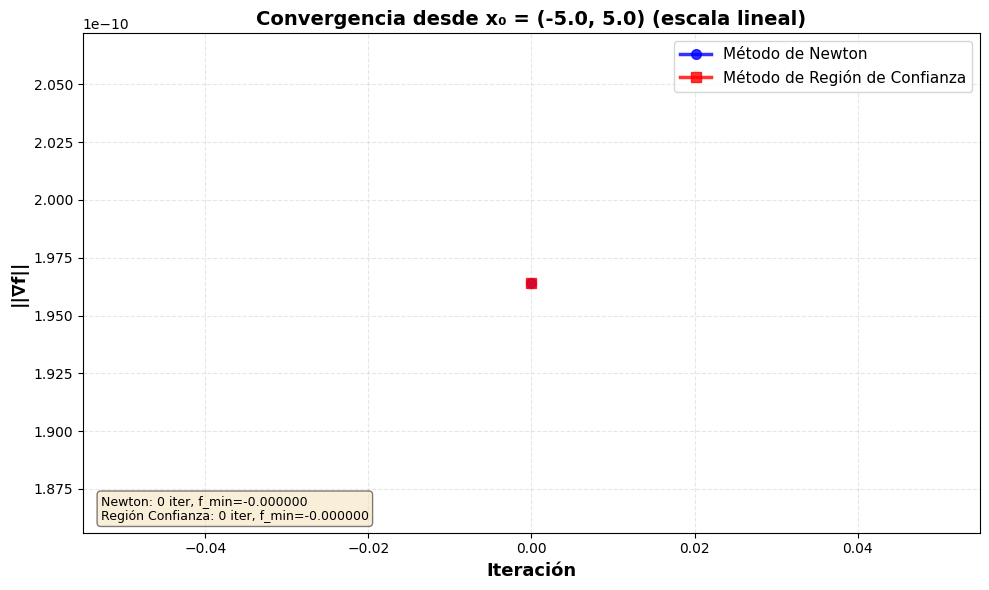

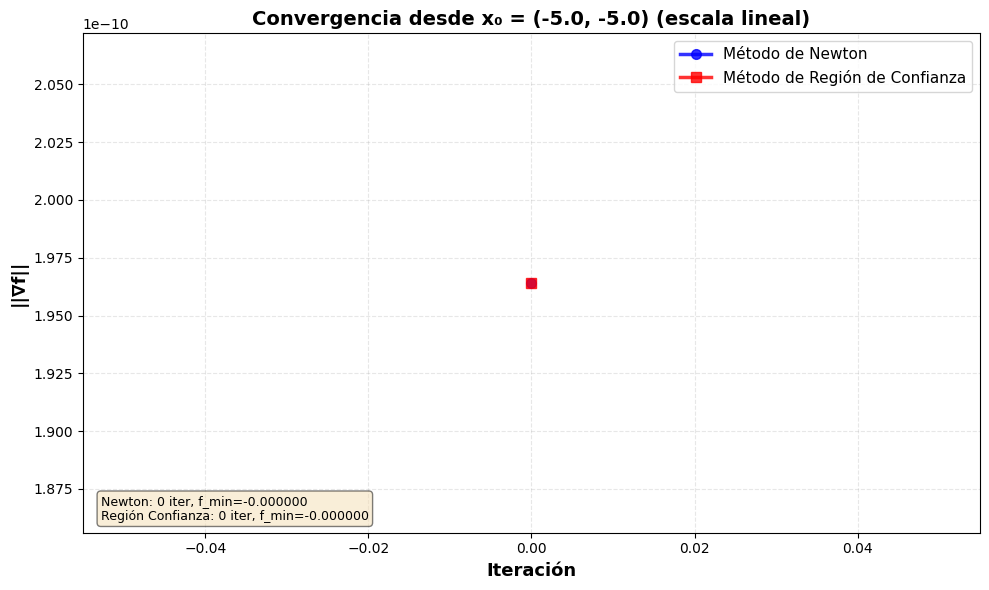

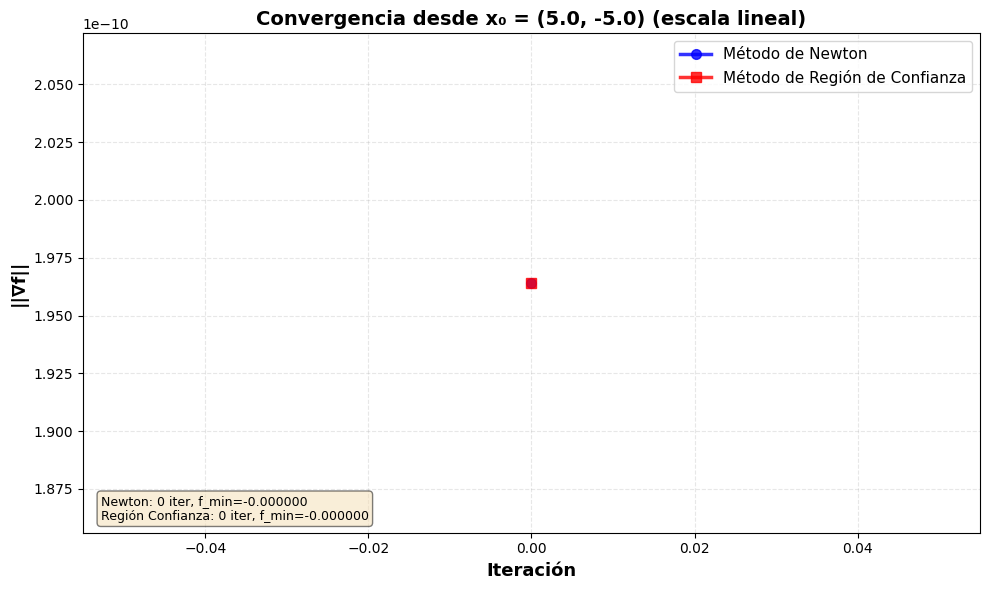

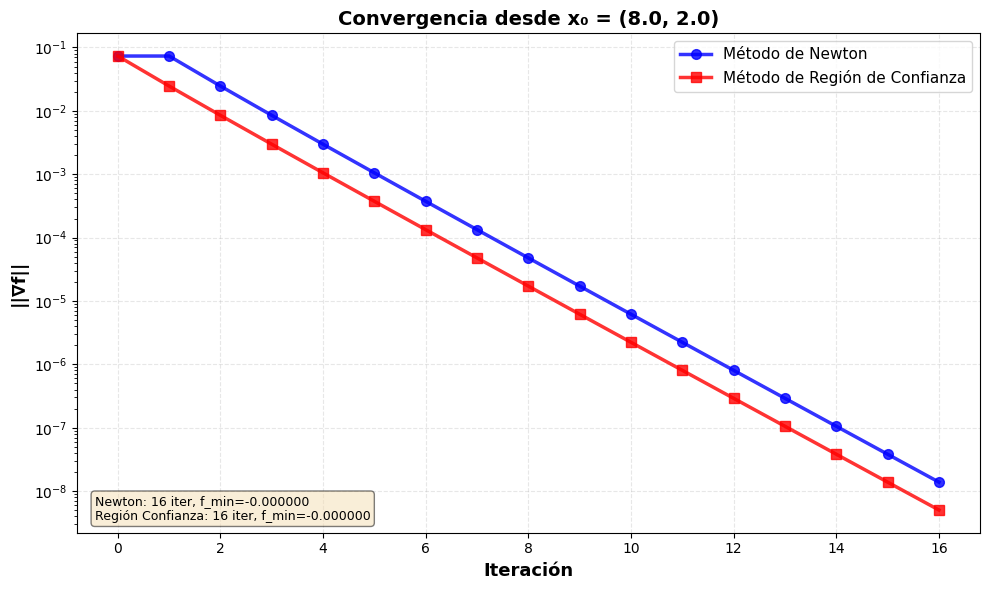

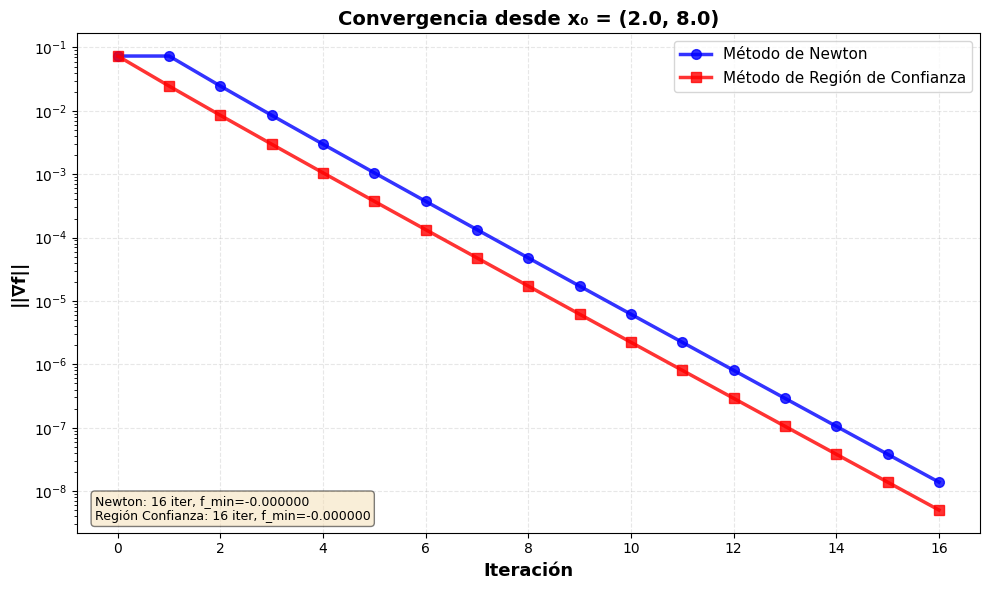

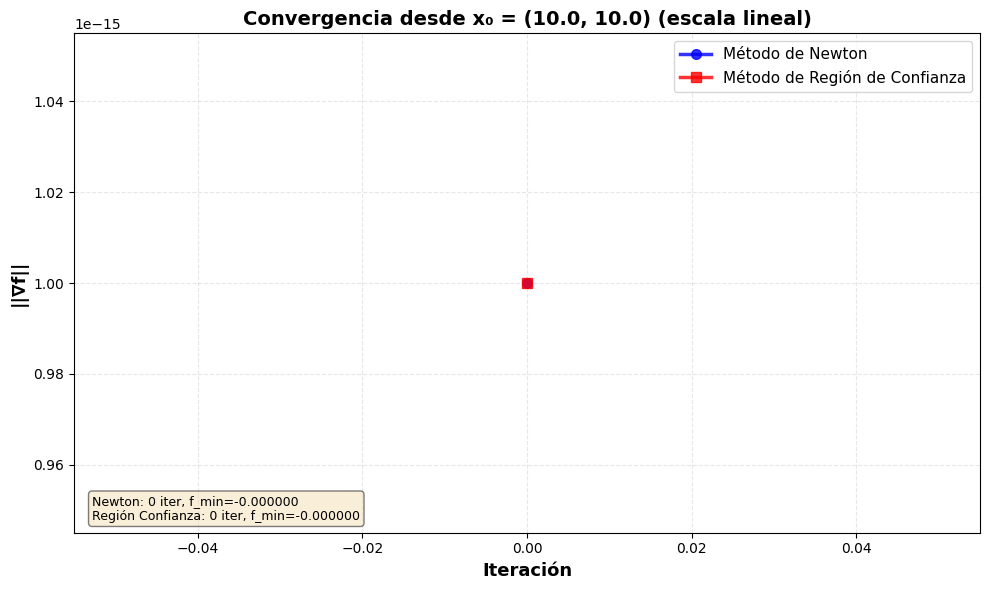

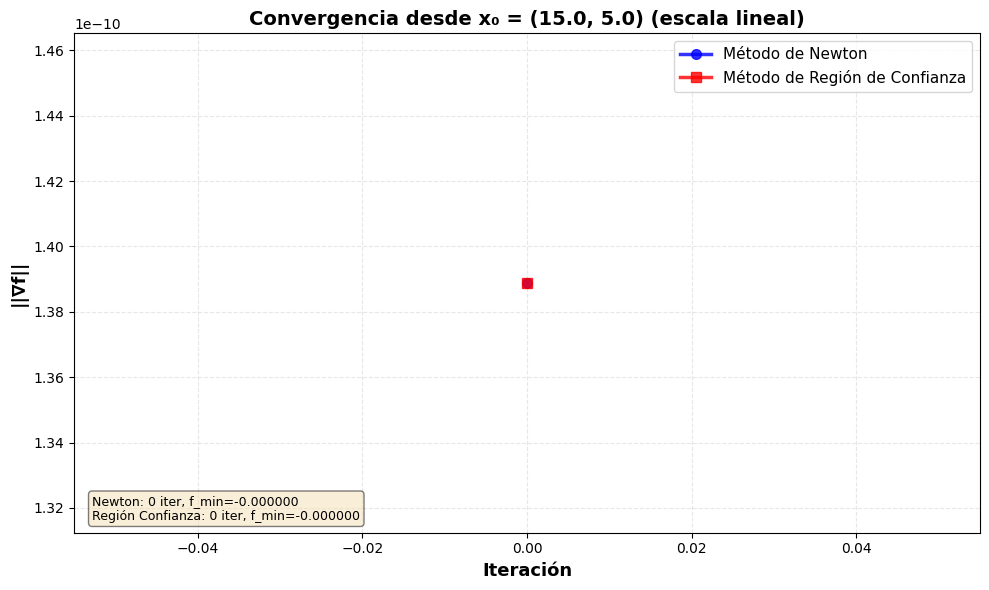

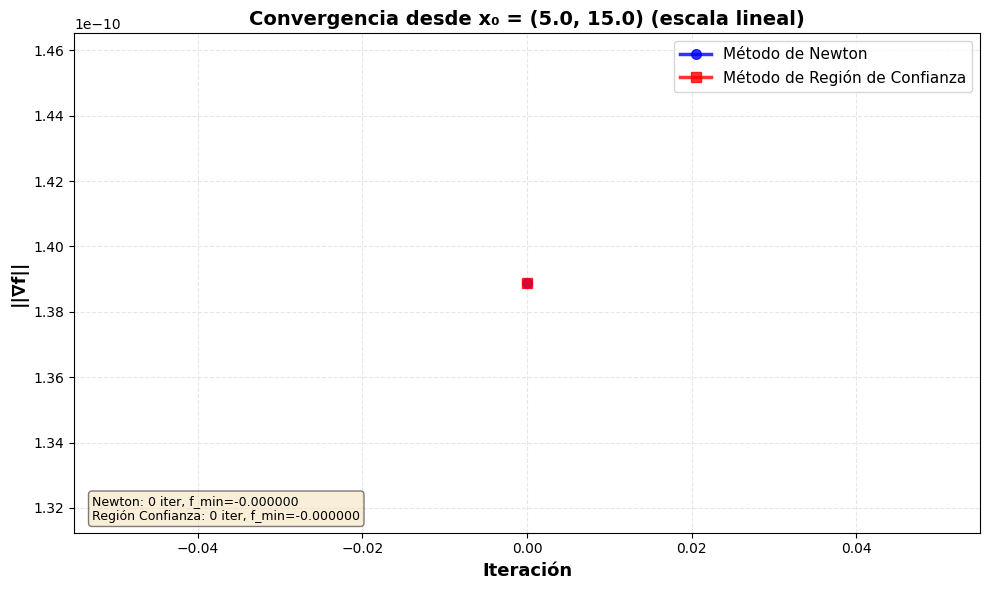

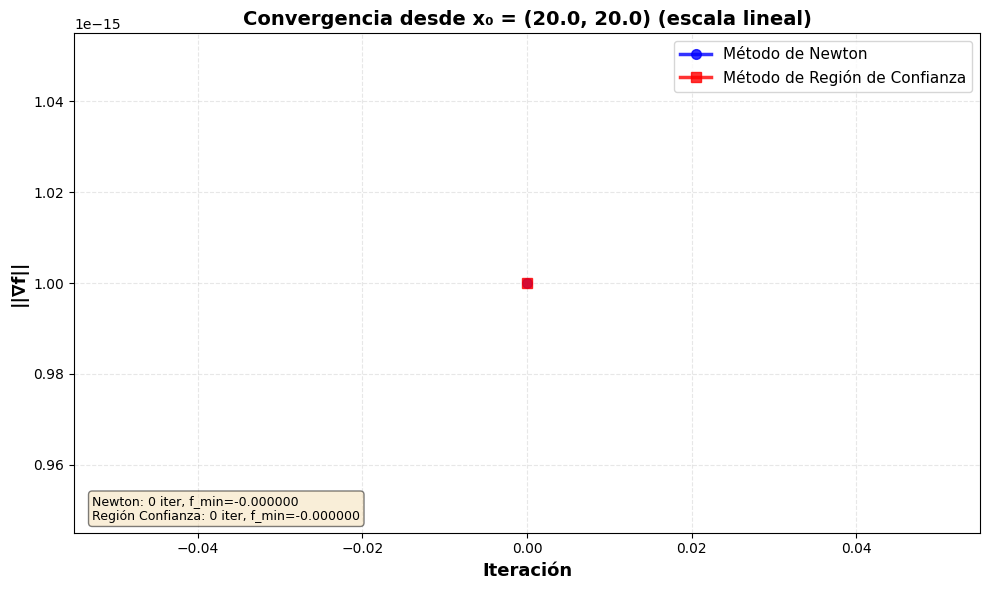

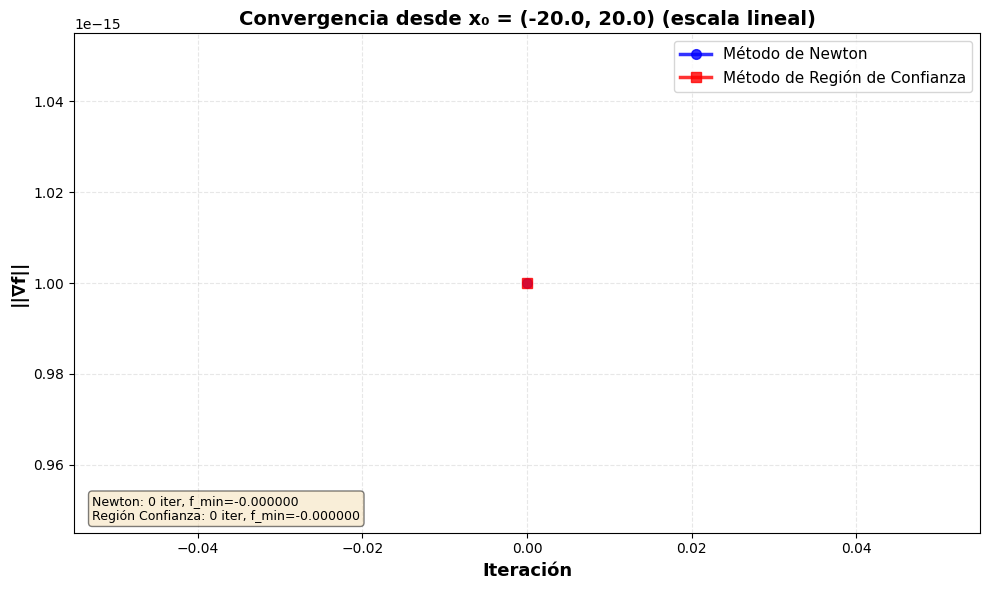

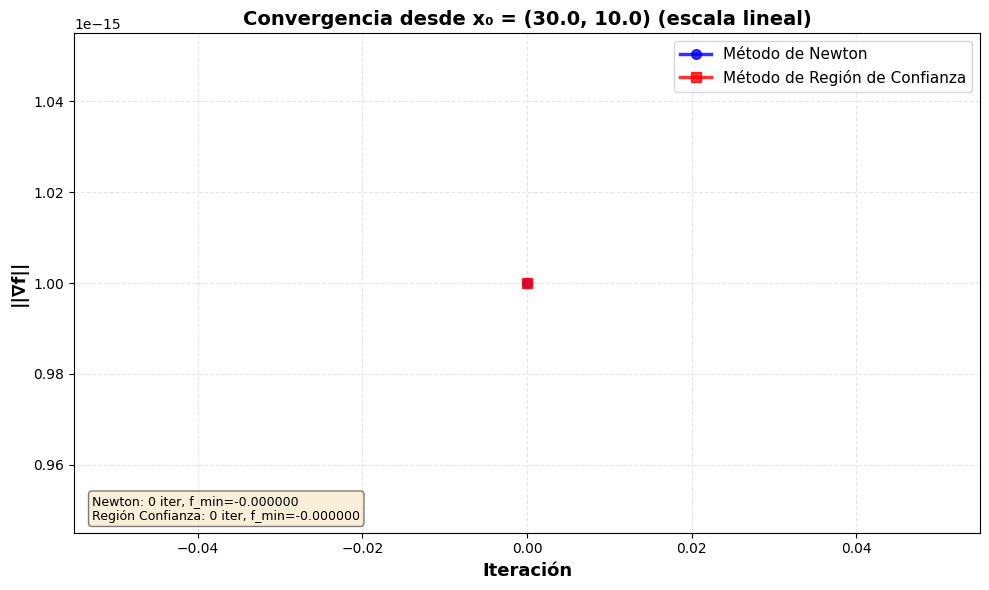

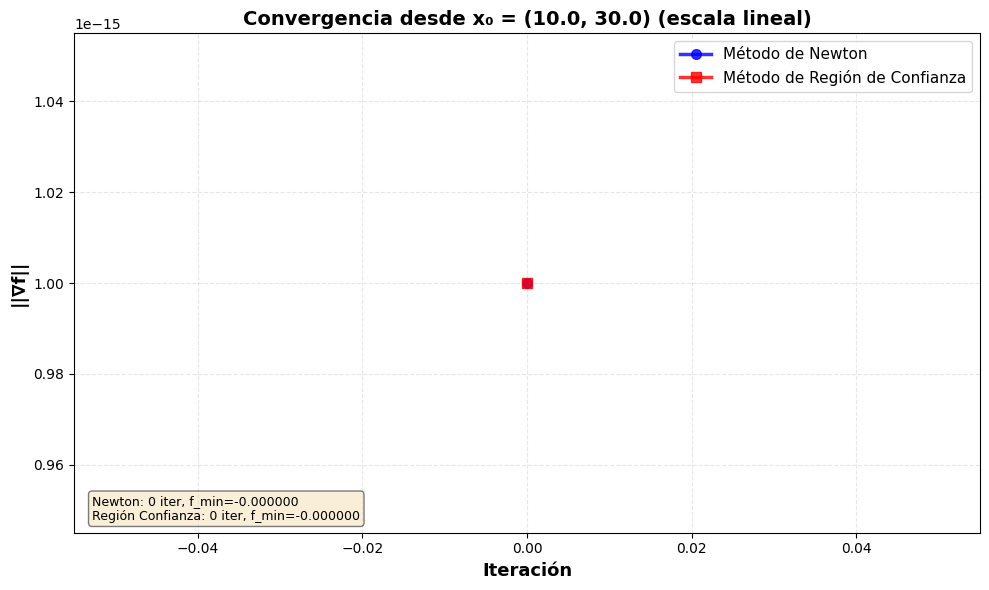

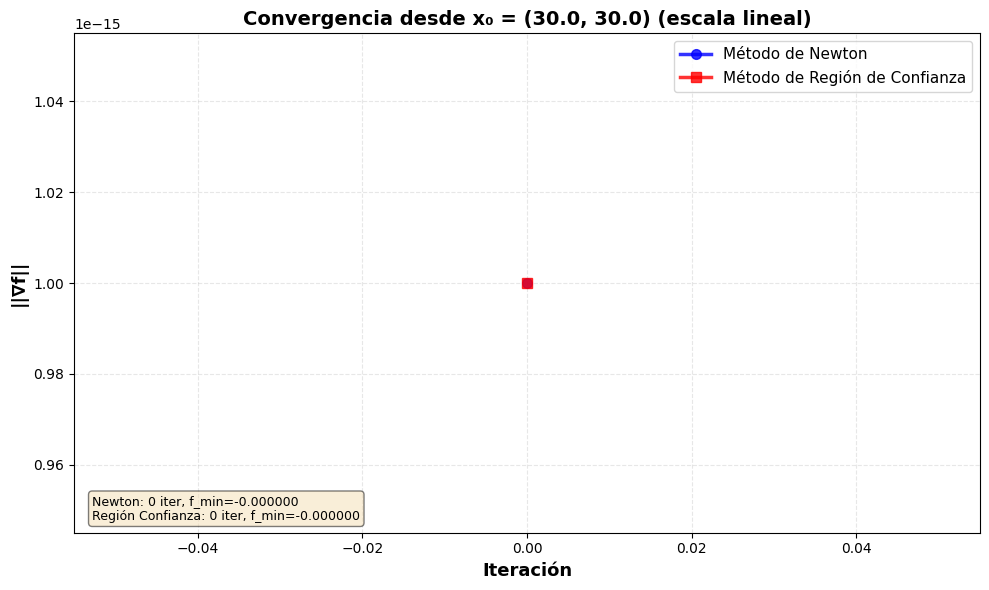

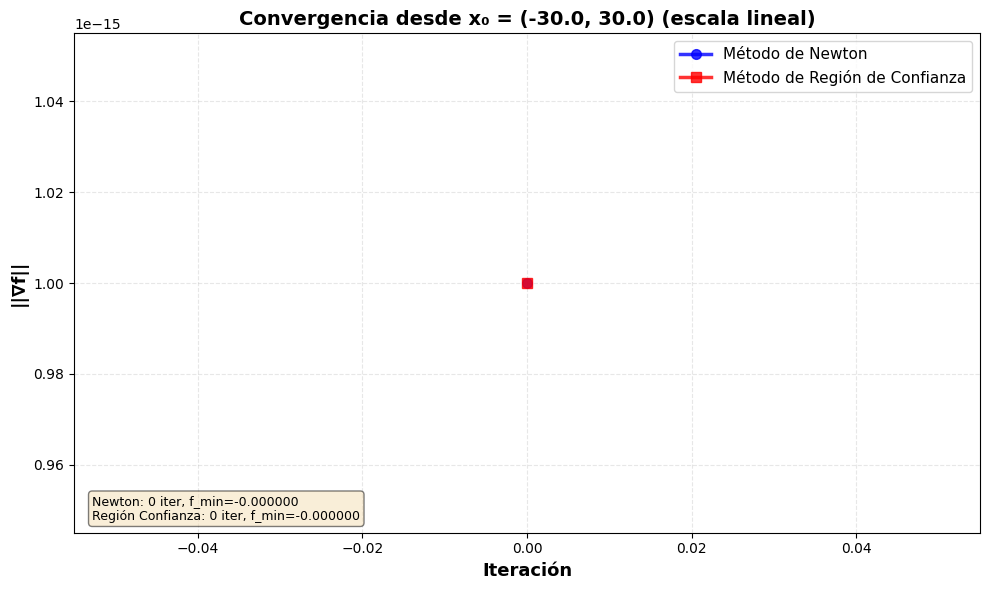

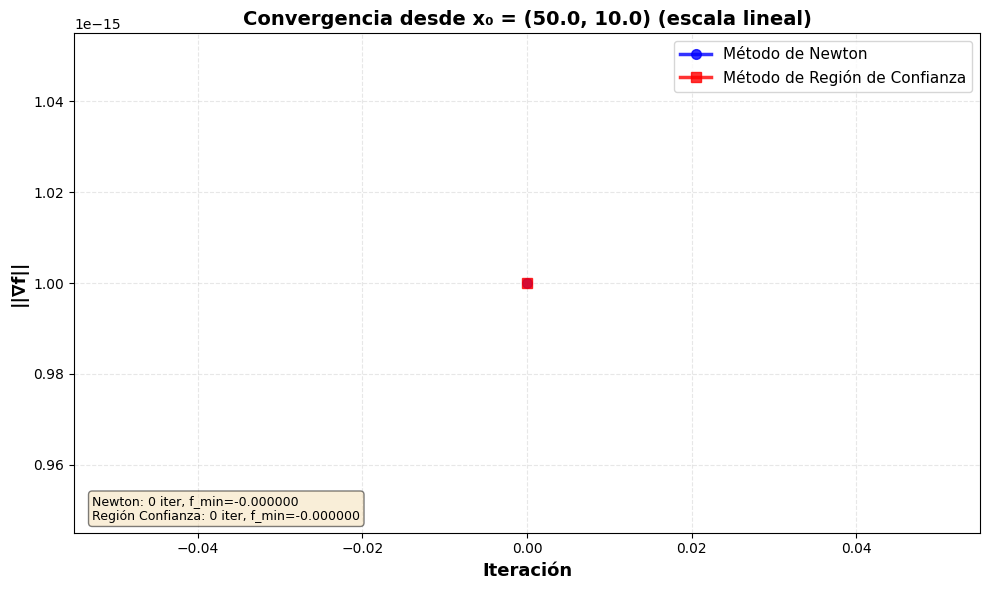

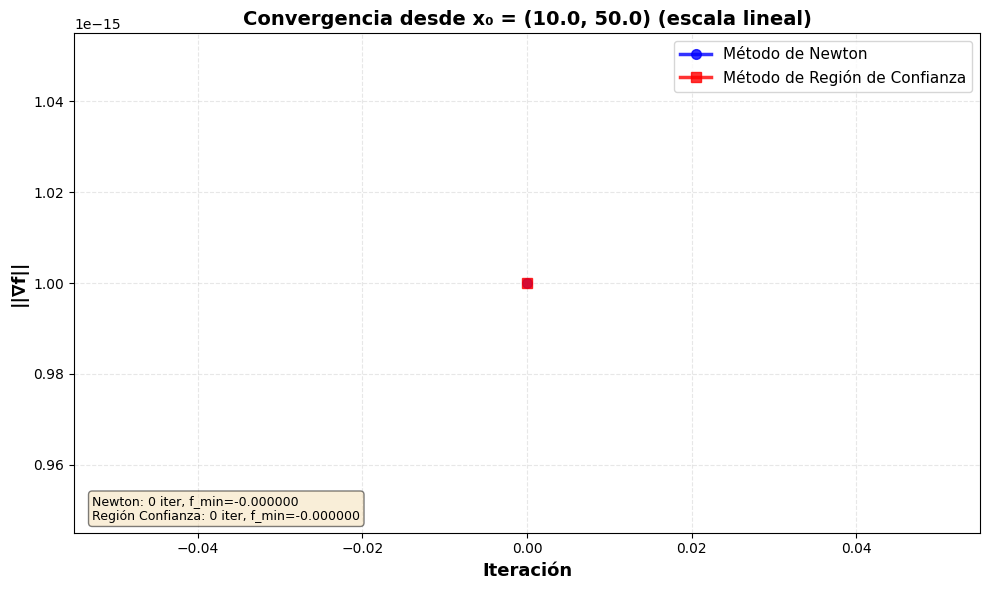

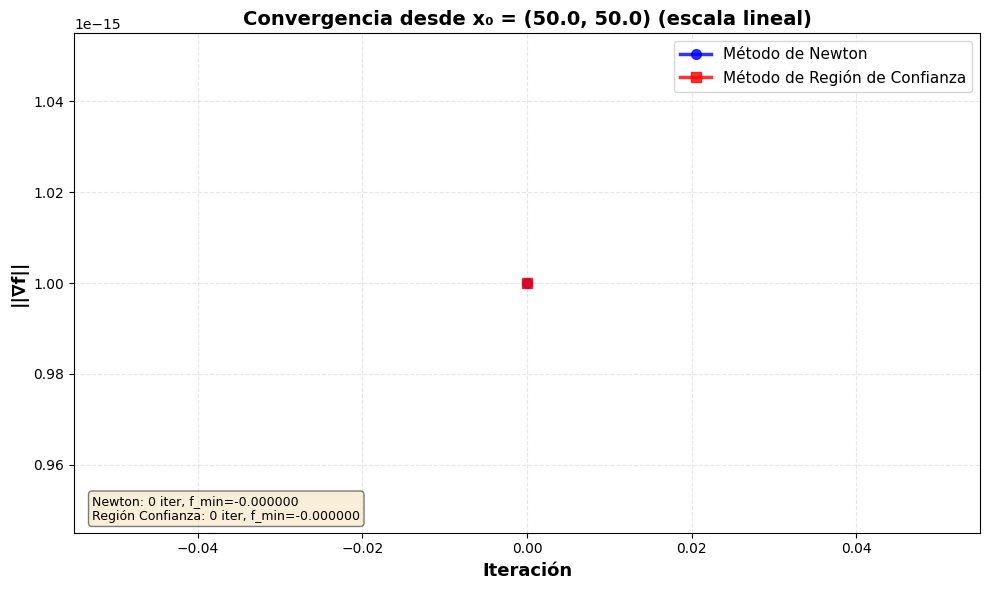

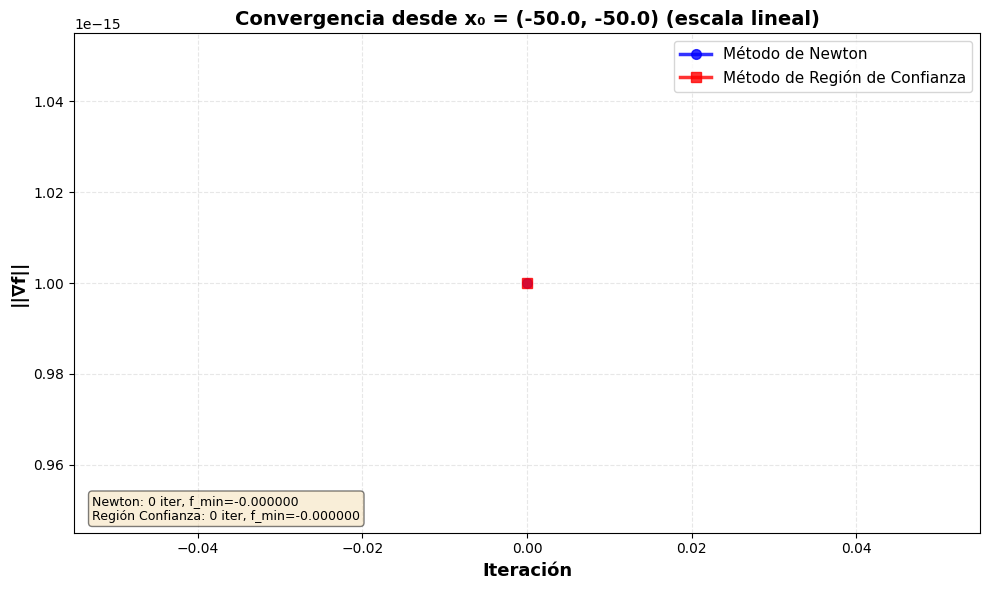

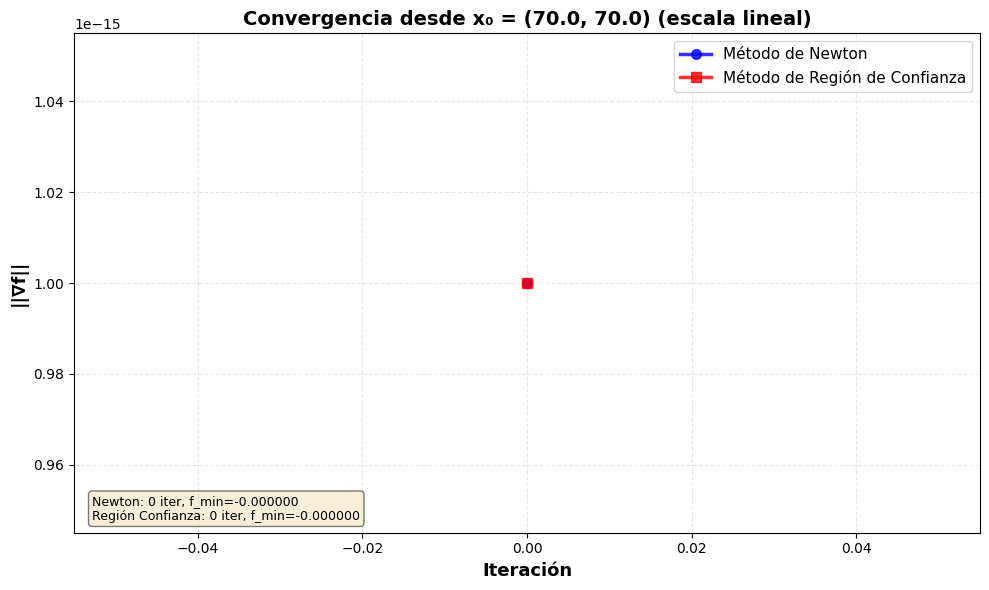

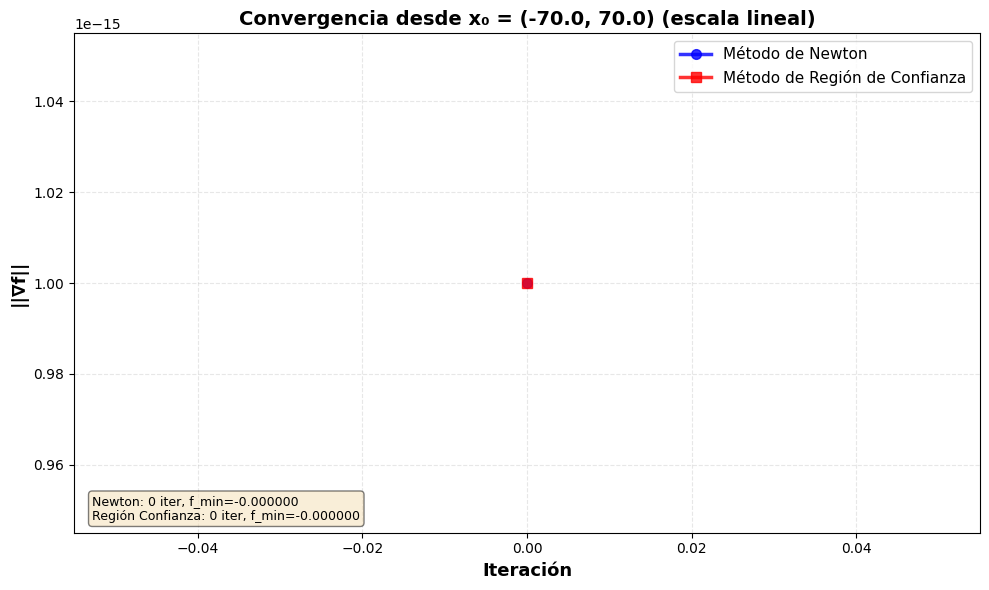

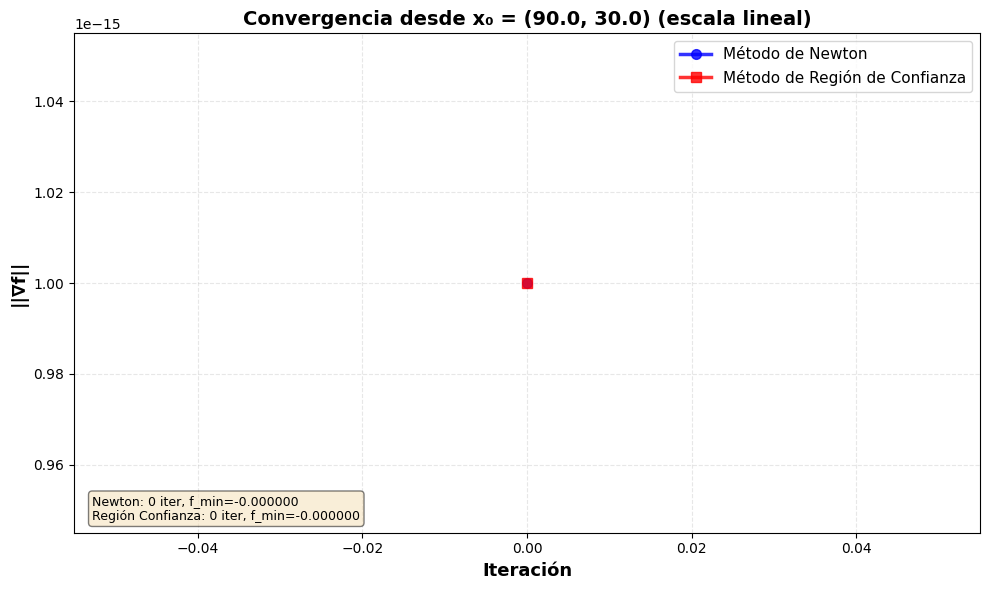

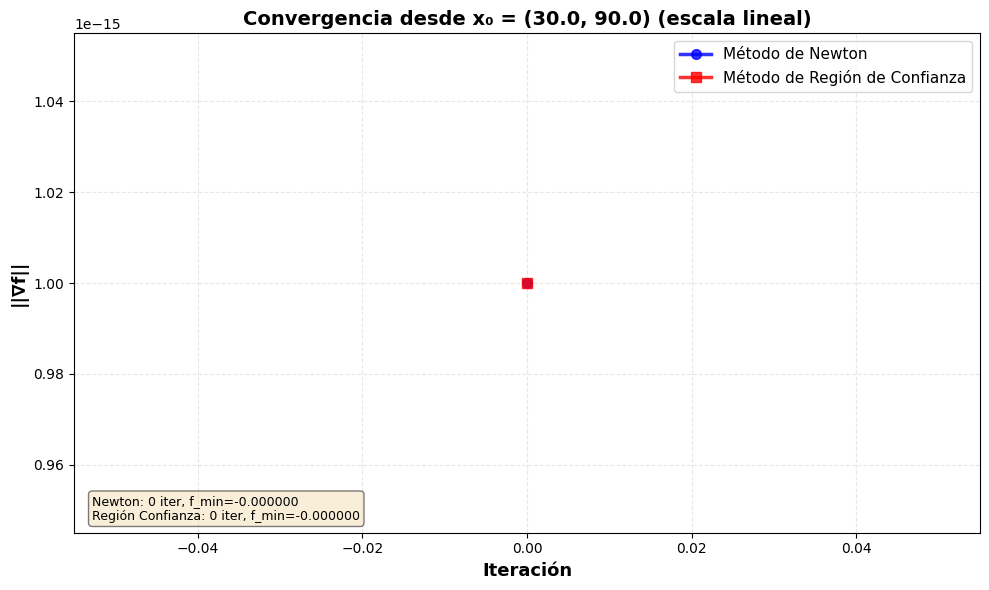

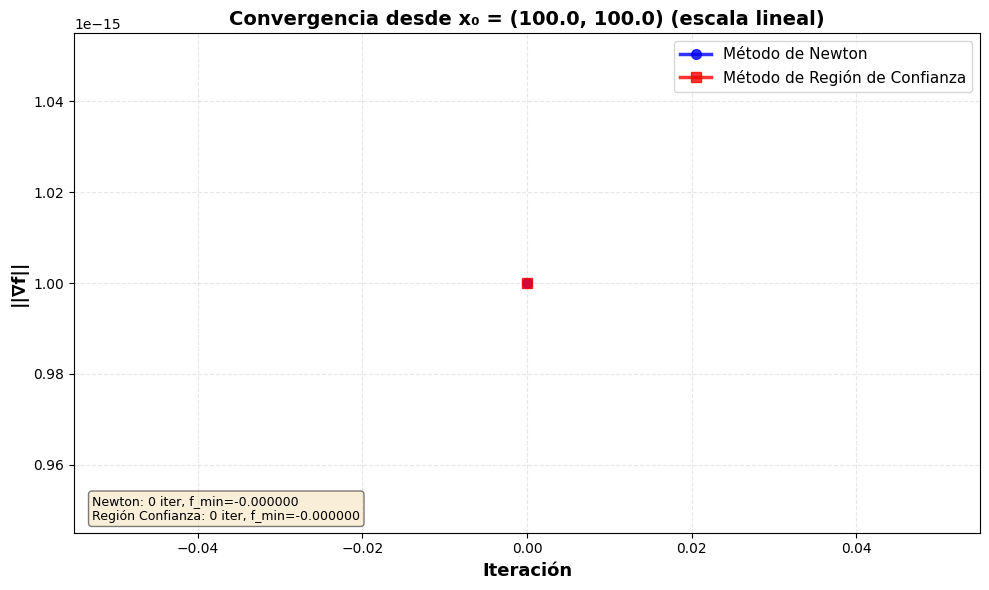

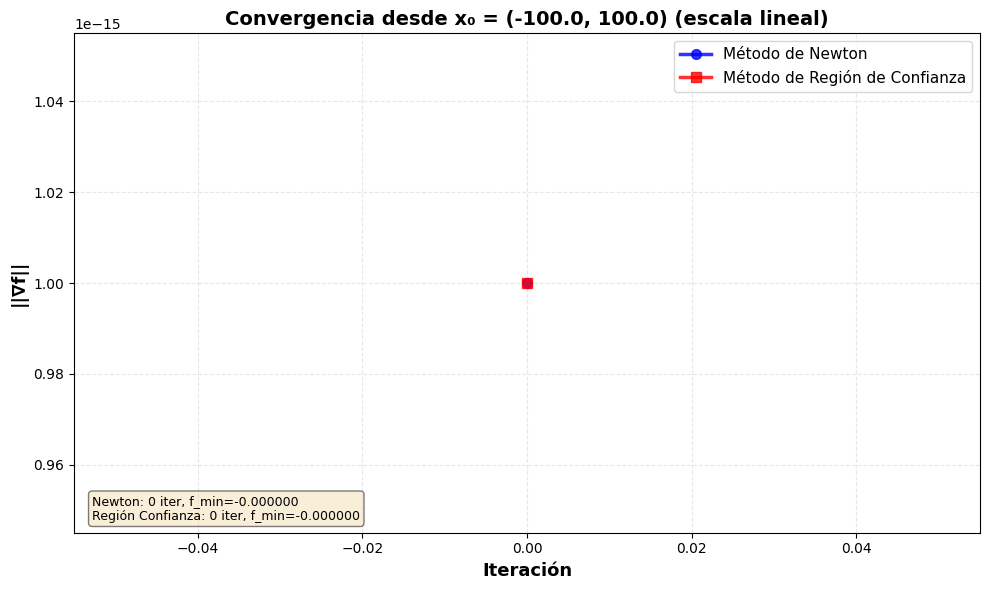

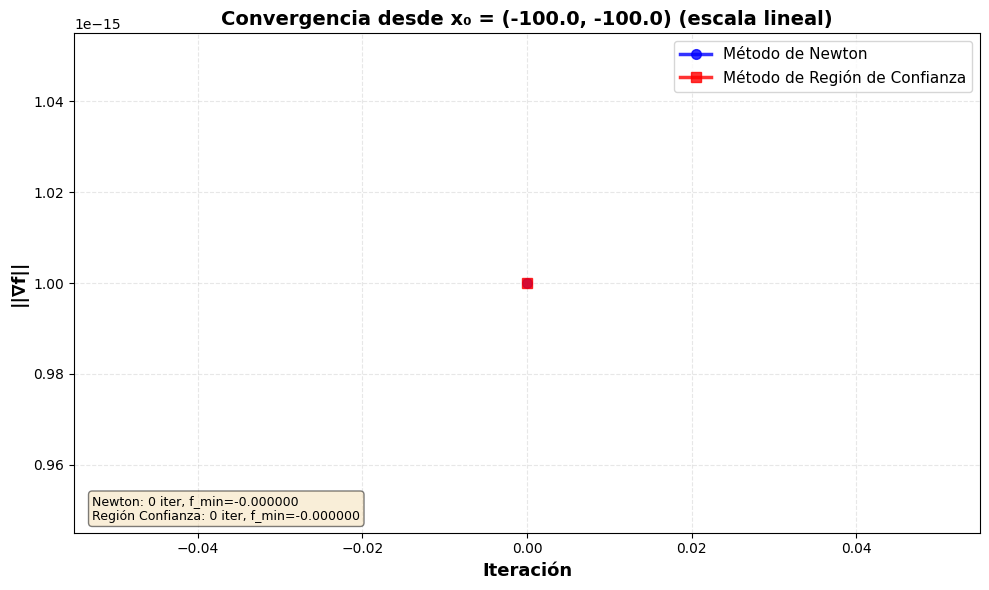

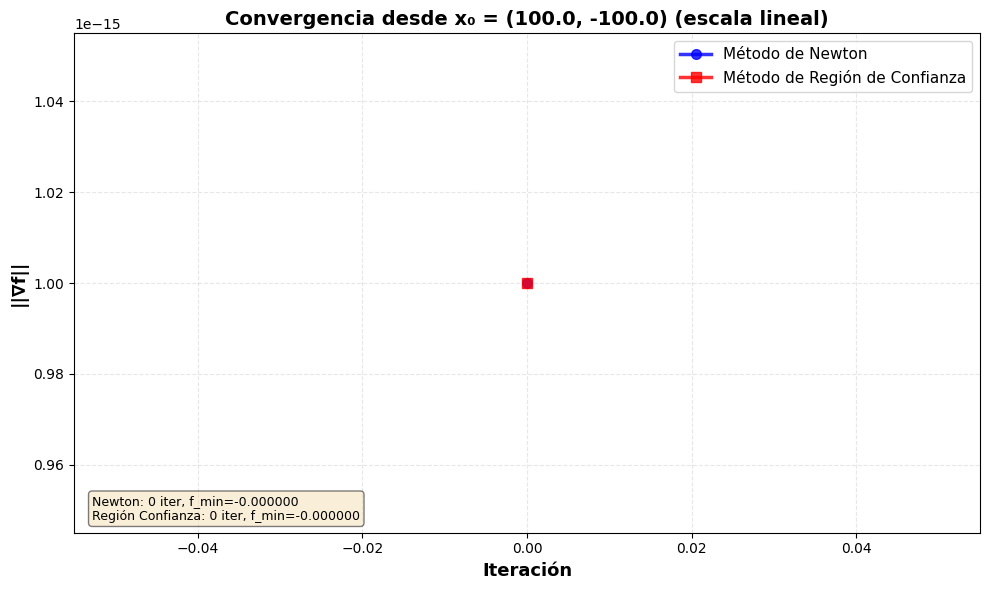

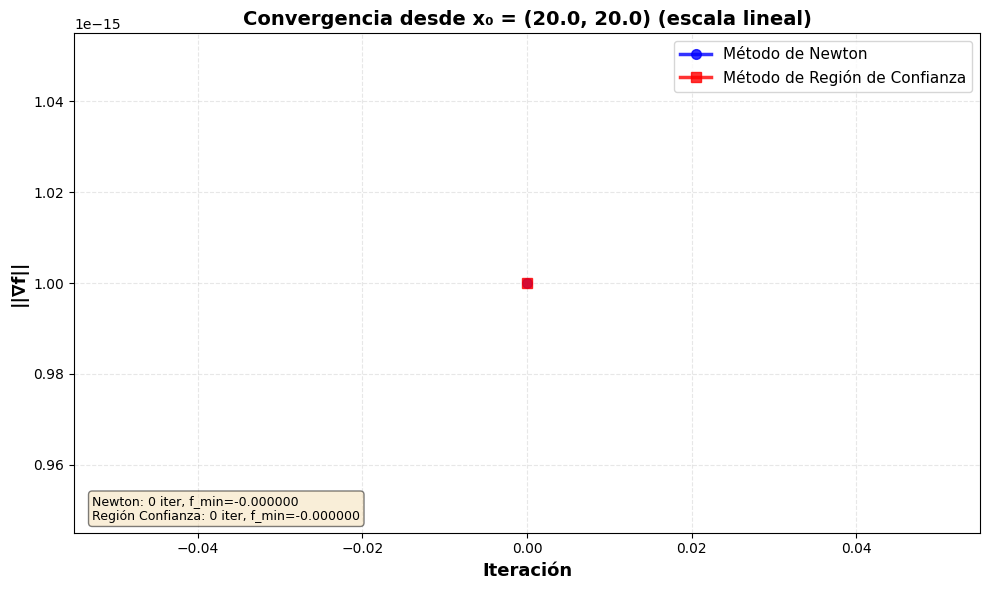

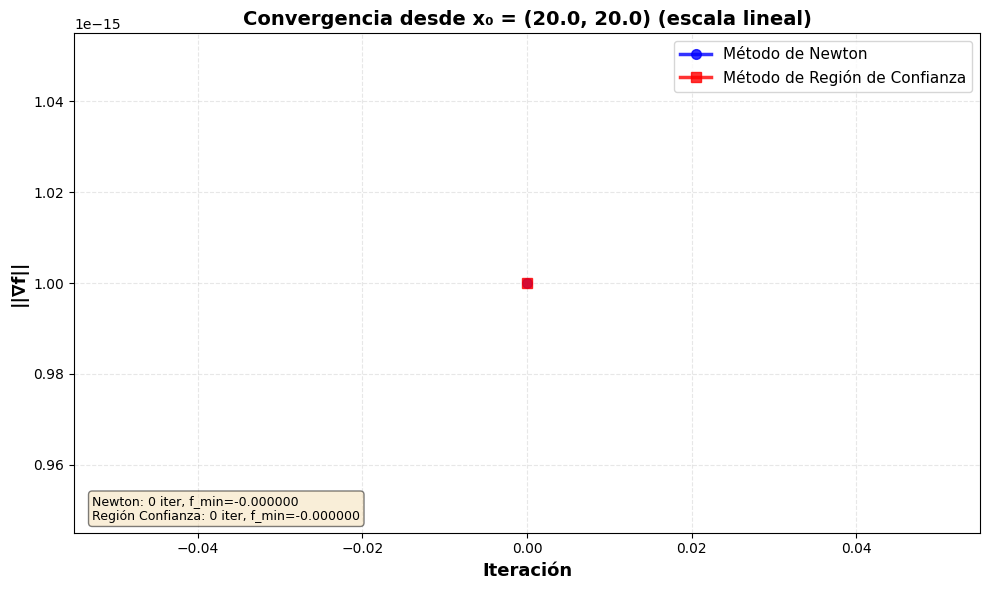

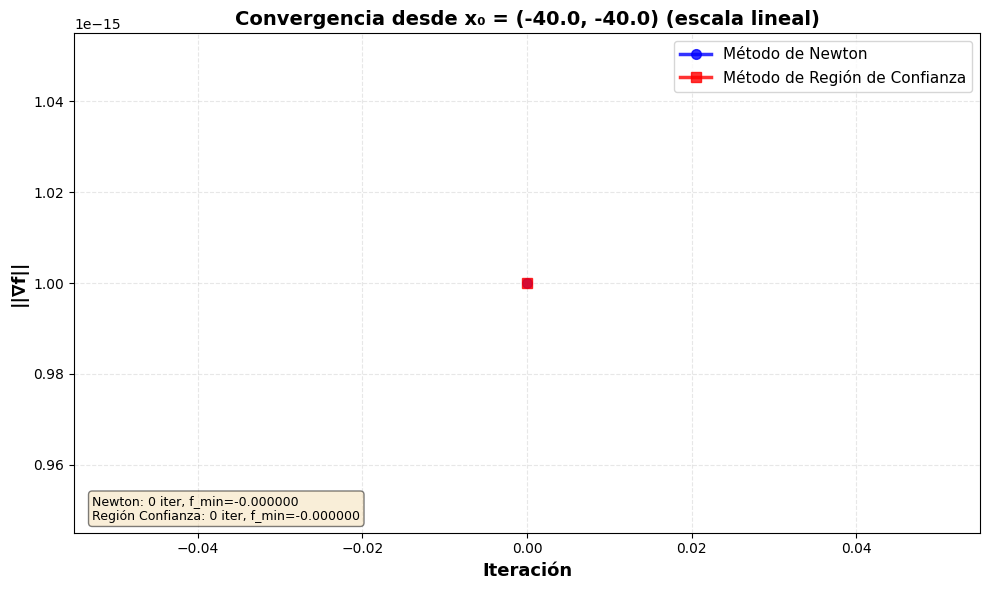

Gráficas generadas exitosamente!


In [20]:
# Generar gráficas de convergencia para cada experimento
print("Generando gráficas de convergencia...\n")

for i in range(len(newton_results)):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Datos del experimento
    x0 = newton_results[i]['x0']
    x0_str = f"({x0[0]}, {x0[1]})"
    
    # Historiales
    newton_hist = newton_results[i]['result']['history']
    tr_hist = trust_region_results[i]['result']['history']
    
    # Verificar si hay suficientes datos para graficar
    newton_norms = newton_hist['grad_norm']
    tr_norms = tr_hist['grad_norm']
    
    # Filtrar valores positivos para escala logarítmica
    newton_norms_clean = [max(n, 1e-15) for n in newton_norms]  # Evitar valores <= 0
    tr_norms_clean = [max(n, 1e-15) for n in tr_norms]
    
    # Verificar si hay valores significativos
    max_norm = max(max(newton_norms_clean), max(tr_norms_clean))
    
    if len(newton_norms) > 1 and max_norm > 1e-14:
        # Graficar Newton
        ax.semilogy(range(len(newton_norms_clean)), 
                    newton_norms_clean, 
                    'b-o', linewidth=2.5, markersize=7, 
                    label='Método de Newton', alpha=0.8)
    elif len(newton_norms) >= 1:
        # Usar escala lineal si solo hay un punto o valores muy pequeños
        ax.plot(range(len(newton_norms_clean)), 
                newton_norms_clean, 
                'b-o', linewidth=2.5, markersize=7, 
                label='Método de Newton', alpha=0.8)
    
    if len(tr_norms) > 1 and max_norm > 1e-14:
        # Graficar Trust Region
        ax.semilogy(range(len(tr_norms_clean)), 
                    tr_norms_clean, 
                    'r-s', linewidth=2.5, markersize=7, 
                    label='Método de Región de Confianza', alpha=0.8)
    elif len(tr_norms) >= 1:
        # Usar escala lineal si solo hay un punto o valores muy pequeños
        ax.plot(range(len(tr_norms_clean)), 
                tr_norms_clean, 
                'r-s', linewidth=2.5, markersize=7, 
                label='Método de Región de Confianza', alpha=0.8)
    
    # Configuración de la gráfica
    ax.set_xlabel('Iteración', fontsize=13, fontweight='bold')
    ax.set_ylabel('||∇f||', fontsize=13, fontweight='bold')
    
    # Usar escala logarítmica solo si tiene sentido
    if max_norm > 1e-10 and (len(newton_norms) > 1 or len(tr_norms) > 1):
        ax.set_yscale('log')
        ax.set_title(f'Convergencia desde x₀ = {x0_str}', fontsize=14, fontweight='bold')
    else:
        ax.set_title(f'Convergencia desde x₀ = {x0_str} (escala lineal)', fontsize=14, fontweight='bold')
    
    ax.legend(fontsize=11, loc='best')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Agregar información adicional
    newton_info = f"Newton: {newton_results[i]['result']['num_iter']} iter, f_min={newton_results[i]['result']['f_min']:.6f}"
    tr_info = f"Región Confianza: {trust_region_results[i]['result']['num_iter']} iter, f_min={trust_region_results[i]['result']['f_min']:.6f}"
    
    ax.text(0.02, 0.02, newton_info + '\n' + tr_info,
            transform=ax.transAxes, fontsize=9,
            verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    # Guardar con nombre descriptivo en carpeta results
    filename = f'results/convergencia_exp_{i+1}_x0_{x0[0]}_{x0[1]}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    
    # Mostrar en el notebook (comentar si genera demasiados gráficos)
    plt.show()
    plt.close()
    
print("Gráficas generadas exitosamente!")
